In [1]:
try:
  import google.colab
  _isColab = True
except:
  _isColab = False
print('You are on Colab: ', _isColab)

You are on Colab:  False


In [2]:
if _isColab:
    %pip install monai nilearn

In [3]:
import os, sys, random
from sys import platform
if _isColab:
    _base_path = '/content'
else:
    _base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(os.path.join(_base_path, 'src'))
from monai.config import print_config
from monai.data import CacheDataset
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,

	CropForegroundd
)
from monai.utils import set_determinism
from utils import make_dataset, make_dataset_on_colab, get_device, get_brats_classes
from plotting import plot_input_output, plot_training_values, plot_prediction
from training import train_test_splitting, training_model, predict_model
from config import get_config
from models import SegResNet
_config = get_config()
print_config()

MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 2.3.0.dev20240314
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 10.2.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0.dev20240314
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.2
einops version: 0.7.0
transformers version: 4.30.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional depen

In [4]:
set_determinism(seed=3)
random.seed(3)

In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
	"""
	Convert labels to multi channels based on BraTS-2023 classes.
	(See src.utils.get_brats_classes)
	"""
	def __call__(self, data):
		d = dict(data)
		for key in self.keys:
			d[key] = get_brats_classes(d[key])
		return d

In [6]:
train_transform = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image', 'label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image', 'label'], axcodes='RAS'), #(Left, Right),(Posterior, Anterior),(Inferior, Superior)
        Spacingd(
            keys=['image', 'label'],
            pixdim=(1.0, 1.0, 1.0),
            mode=('bilinear', 'nearest'),
        ),
        RandSpatialCropd(keys=['image', 'label'], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
        RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=1),
        RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys='image', factors=0.1, prob=1.0),
        RandShiftIntensityd(keys='image', offsets=0.1, prob=1.0),
    ]
)
eval_transform = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image', 'label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        Spacingd(
            keys=['image', 'label'],
            pixdim=(1.0, 1.0, 1.0),
            mode=('bilinear', 'nearest'),
        ),
        NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    ]
)
test_transform = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image'], axcodes='RAS'),
        Spacingd(
			keys=['image'],
			pixdim=(1.0, 1.0, 1.0),
			mode='bilinear'
		),
        NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    ]
)
post_test_transforms = Compose(
    [
        Invertd(
            keys='pred',
            transform=test_transform,
            orig_keys='image',
            meta_keys='pred_meta_dict',
            orig_meta_keys='image_meta_dict',
            meta_key_postfix='meta_dict',
            nearest_interp=False,
            to_tensor=True,
            device='cpu',
        ),
        Activationsd(keys='pred', sigmoid=True),
        AsDiscreted(keys='pred', threshold=0.5),
    ]
)
post_trans = Compose(
	[
		Activations(sigmoid=True),
		AsDiscrete(threshold=0.5)
	]
)

In [7]:
data_path = make_dataset_on_colab('glioma', False) if _isColab else make_dataset('glioma', False)
train_data, eval_data, test_data = train_test_splitting(data_path)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            724 (64.0 %)        182 (16.0 %)        227 (20.0 %)        

sessions            798 (63.79 %)       210 (16.79 %)       243 (19.42 %)       



Input image shape: torch.Size([4, 224, 224, 144])
Input label shape: torch.Size([3, 224, 224, 144])


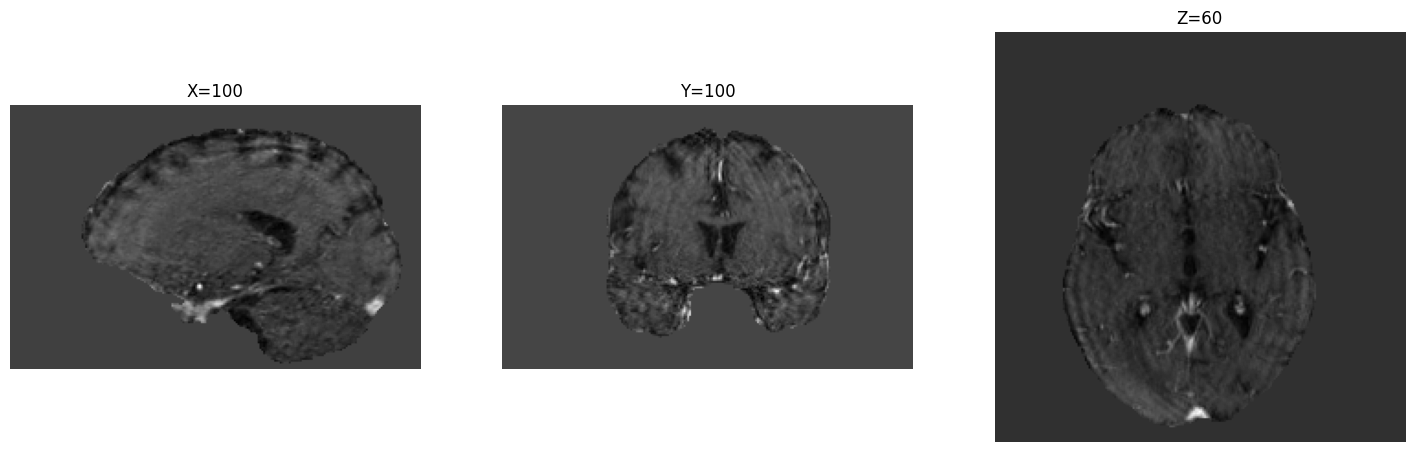

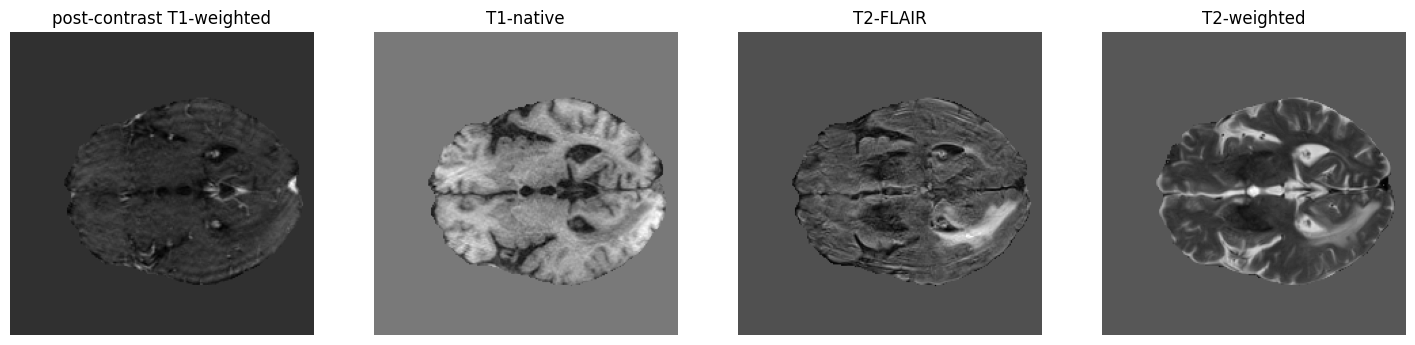

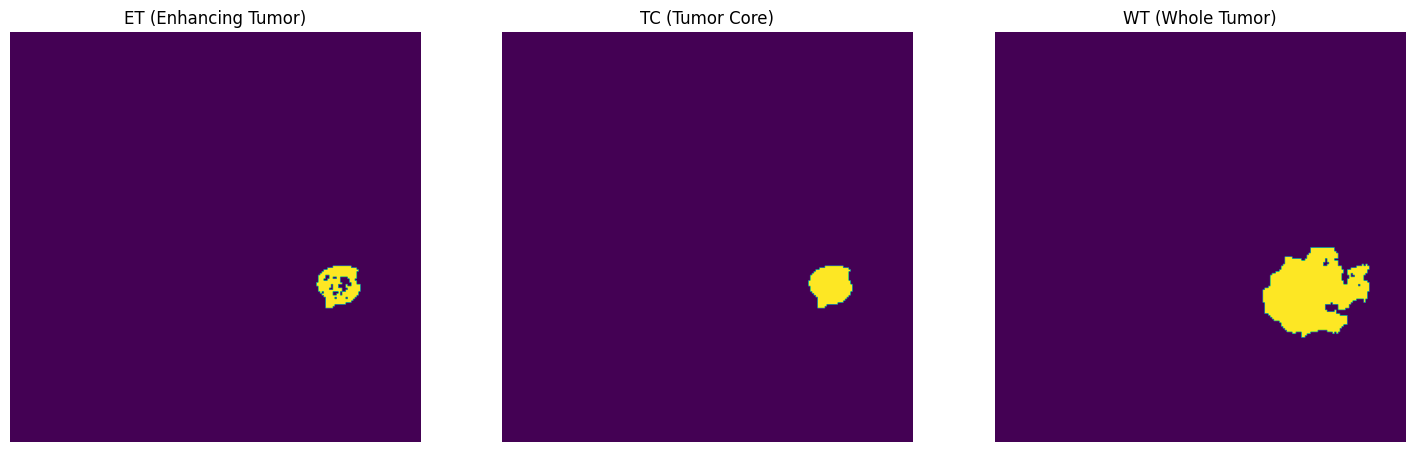

In [15]:
sample_ds = CacheDataset(train_data[:1], transform=train_transform, progress=False)
print(f"Input image shape: {sample_ds[0]['image'].shape}")
print(f"Input label shape: {sample_ds[0]['label'].shape}")
plot_input_output(sample_ds[0])

In [9]:
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
preds_path = os.path.join(_base_path, _config.get('PRED_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))

if platform == 'win32':
	saved_path = saved_path.replace('/', '\\')
	reports_path = reports_path.replace('/', '\\')
	preds_path = preds_path.replace('/', '\\')
	logs_path = logs_path.replace('/', '\\')

if _isColab:
    if not os.path.isdir(saved_path):
        os.mkdir(saved_path)
    if not os.path.isdir(reports_path):
        os.mkdir(reports_path)
    if not os.path.isdir(preds_path):
        os.mkdir(preds_path)
    if not os.path.isdir(logs_path):
        os.mkdir(logs_path)

In [10]:
## NOTE: uncomment to execute the training phase.

# train_metrics = training_model(
# 	model = SegResNet(init_filters=16, in_channels=4, out_channels=3, dropout_prob=0.2),
# 	data = [train_data, eval_data],
# 	transforms = [train_transform, eval_transform, post_trans],
# 	epochs = 6,
# 	device = get_device(),
# 	paths = [saved_path, reports_path, logs_path],
# 	num_workers=0
# )

In [11]:
plot_training_values(model_name='SegResNet', folder=reports_path)


> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ERROR: model report for SegResNet not found.

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 



In [12]:
## NOTE: uncomment to execute the prediction on the testing set.

# test_metrics = predict_model(
# 	model = SegResNet(init_filters=16, in_channels=4, out_channels=3, dropout_prob=0.2),
# 	data = test_data,
# 	transforms = [test_transform, post_test_transforms],
# 	device = get_device(),
# 	paths = [saved_path, reports_path, preds_path, logs_path],
# 	num_workers=0
# )

In [13]:
plot_prediction('SegResNet', preds_path)


> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ERROR: sample predictions for SegResNet not found.

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 



In [14]:
# dice, hausdorff = test_metrics
# print(''.join(['> ' for i in range(40)]))
# print(f'\n{"":<20}{"ET":<20}{"TC":<20}{"WT":<20}\n')
# print(''.join(['> ' for i in range(40)]))
# print(f'\n{"Dice Score":<20}{dice[0]:<20.4f}{dice[1]:<20.4f}{dice[0]:<20.4f}\n')
# print(f'{"Hausdorff[95%]":<20}{hausdorff[0]:<20.4f}{hausdorff[1]:<20.4f}{hausdorff[2]:<20.4f}\n')